### - import libraries

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from time import time
from tqdm import tqdm
import pickle
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

In [2]:
# Set random seem for reproducibility
manualSeed = 2019
torch.manual_seed(manualSeed)
np.random.seed(manualSeed)

In [3]:
ngpu = torch.cuda.device_count()
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

### - import data

In [4]:
def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
dataset = load_obj('kdd99')
x_train = dataset['x_train']
y_train = dataset['y_train']
x_valid = dataset['x_valid']
y_valid = dataset['y_valid']
x_test = dataset['x_test']
y_test = dataset['y_test']

x_train = torch.tensor(x_train, device=device)
# y_train = torch.tensor(y_train, device=device)
x_valid = torch.tensor(x_valid, device=device)
# y_valid = torch.tensor(y_valid, device=device)
x_test = torch.tensor(x_test, device=device)
# y_test = torch.tensor(y_test, device=device)

### - define hyper-parameters

In [5]:
G_D_num = 10
G_group = {}
D_group = {}
z_avg = 0
BATCH_SIZE = 128
EPOCH = 10
LR_G = 0.1  # learning rate for generator
LR_D = 0.1  # learning rate for discriminator
random_neuron = 100  # number of neurons as input of generator
components = 121  # total number of points that G generated
critic_num = 5
D_loss_history = []
G_loss_history = []
alpha = 0.1

### - define network class

In [6]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Linear(random_neuron, 128),
            nn.ReLU(True),
            nn.Linear(128, 128),
            nn.ReLU(True),
            nn.Linear(128, components)
        )

    def forward(self, input):
        return self.main(input)

In [7]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Linear(components, 128),
            nn.ReLU(True),
            nn.Linear(128, 128),
            nn.ReLU(True),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

### - training

100%|██████████| 10/10 [02:53<00:00, 17.32s/it]


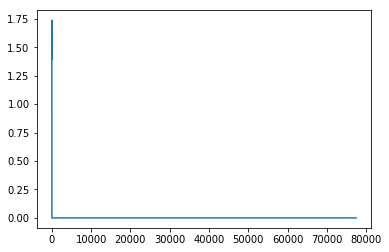

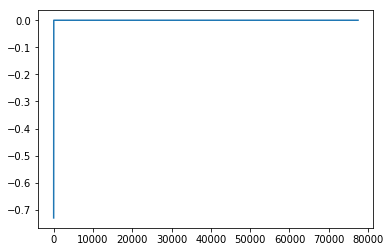

1/10 is done! Time is 173.63 seconds;


  0%|          | 0/10 [00:00<?, ?it/s]

Precision score: 0.20
Recall score: 0.00
F1 score: 0.00
*************************************************************


KeyboardInterrupt: 

In [8]:
for iter in range(G_D_num):

    begin = time()

    D = Discriminator(ngpu).to(device)
    G = Generator(ngpu).to(device)

    # optimization
    opt_D = torch.optim.Adam(D.parameters(), lr=LR_D)
    opt_G = torch.optim.Adam(G.parameters(), lr=LR_G)

    for step in tqdm(range(EPOCH)):
        
        for batch_iter in range(x_train.shape[0] // BATCH_SIZE):
            
            selected_real = x_train[batch_iter * BATCH_SIZE:(batch_iter * BATCH_SIZE + BATCH_SIZE)].float()
            for _ in range(critic_num):

                # random samples of real data
#                 idx = np.random.choice(len(x_train), BATCH_SIZE)
#                 selected_real = x_train[idx].float()

                # random noises
                G_noise = torch.randn(BATCH_SIZE, random_neuron).cuda()
                G_data = G(G_noise)

                prob_real = D(selected_real)  # D try to increase this prob
                prob_fake = D(G_data)  # D try to decrease this prob

                D_loss = -torch.mean(
                    torch.log(prob_real + 1e-9) + torch.log(1. - prob_fake + 1e-9))
                G_loss = torch.mean(torch.log(1. - prob_fake + 1e-9))
                
                D_loss_history.append(D_loss.item())
                G_loss_history.append(G_loss.item())

                opt_D.zero_grad()
                D_loss.backward(retain_graph=True)  # reusing computational graph
                opt_D.step()

            opt_G.zero_grad()
            G_loss.backward()
            opt_G.step()
    
    plt.plot(D_loss_history)
    plt.show()
    plt.plot(G_loss_history)
    plt.show()
    
    end = time()
    print(
        str(iter + 1) + '/' + str(G_D_num) +
        ' is done! Time is {0:0.2f} seconds;'.format((end - begin)))

    prediction = D(x_test.float()).cpu().detach().numpy()
    tmp_score = np.zeros_like(prediction)
    for i in range(prediction.shape[0]):
        if prediction[i] > alpha:
            tmp_score[i] = 0
        else:
            tmp_score[i] = 1

    precision = average_precision_score(y_test.reshape([-1, 1]), tmp_score)
    recall = recall_score(y_test.reshape([-1, 1]), tmp_score)
    F1 = 2 * (precision * recall) / (precision + recall)
    print('Precision score: {0:0.2f}'.format(precision))
    print('Recall score: {0:0.2f}'.format(recall))
    print('F1 score: {0:0.2f}'.format(F1))
    print('*************************************************************')

    G_group['G' + str(iter)] = G
    D_group['D' + str(iter)] = D

---

# evaluation

In [ ]:
test_score = 0.0
for iter in range(G_D_num):
    prediction = D_group['D' + str(iter)](x_test.float()).cpu().detach().numpy()
    test_score = test_score + prediction / G_D_num

for i in range(test_score.shape[0]):
    if test_score[i] > alpha:
        test_score[i] = 0
    else:
        test_score[i] = 1

precision = average_precision_score(y_test.reshape([-1,1]), test_score)
recall = recall_score(y_test.reshape([-1,1]), test_score)
F1 = 2 * (precision * recall) / (precision + recall)
print('Precision score: {0:0.2f}'.format(precision))
print('Recall score: {0:0.2f}'.format(recall))
print('F1 score: {0:0.2f}'.format(F1))

---

In [10]:
for param in D.parameters():
    print(param.data)

tensor([[-0.5256,  0.7296, -0.4394,  ...,  0.5928,  0.8180, -0.4982],
        [-0.4238, -0.3940, -0.4305,  ...,  0.5134, -0.4331, -0.6987],
        [ 0.7150,  0.5640,  0.6016,  ..., -0.6546, -0.8226,  0.5721],
        ...,
        [ 0.7183,  0.5933,  0.7248,  ..., -0.6559, -1.0558,  0.6526],
        [-0.4082, -0.5156, -0.4252,  ...,  0.3791,  0.0143, -0.5689],
        [-0.5460, -0.6454, -0.6115,  ...,  0.5173,  0.6218, -0.5864]],
       device='cuda:0')
tensor([ 0.6590, -0.8319,  0.5743,  0.6139, -0.6555, -0.8128, -0.0811,  0.6027,
         0.7561, -0.5089,  0.6165,  0.6623,  0.8874, -0.3527, -0.6965, -0.6590,
         0.8374, -0.5074,  0.6287,  0.6522,  0.8154,  0.6701, -0.4013, -0.4554,
        -0.6992, -0.1092, -0.5221, -0.6278, -0.5236, -0.7296,  0.7349, -0.7531,
        -0.5527, -0.0148,  0.6093,  0.5615, -0.6414, -0.6373,  0.7297,  0.0174,
        -0.6394, -0.0557, -0.7286, -0.6705,  0.6150, -0.4886, -0.3049, -0.6915,
        -0.6452, -0.6843, -0.2887,  0.6949, -0.5207,  0.7790, 